# Предсказание цен на дома, регрессия

## Предообработка

In [1]:
from keras.datasets import boston_housing
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

57026/57026 [==============================] - 0s 1us/step


Normalization

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Конструирование сети

In [3]:
from keras import models, layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', 
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## Оценка решения методом перекрестной проверки по K блокам

In [5]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_targets = train_target[i*num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i*num_val_samples], 
                                         train_data[(i+1)*num_val_samples:]],
                                         axis = 0)
    partial_train_targets = np.concatenate([train_target[:i * num_val_samples],
                                            train_target[(i+1)*num_val_samples:]],
                                            axis=0)
    
    model = build_model()
    history =model.fit(partial_train_data, partial_train_targets,
                       validation_data=(val_data, val_targets), 
                       epochs=num_epochs, batch_size=1, verbose=0)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    # all_scores.append(val_mae)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [6]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) 
                       for i in range(num_epochs)]

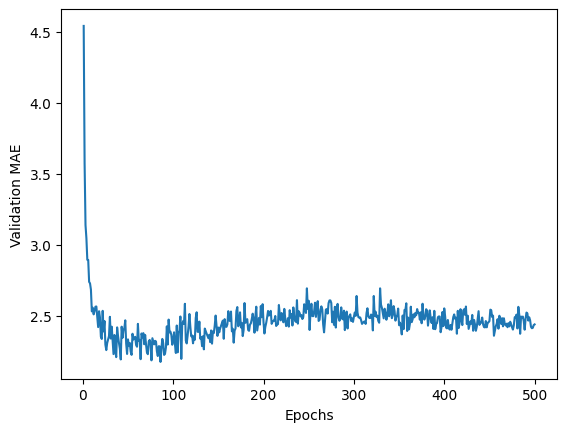

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

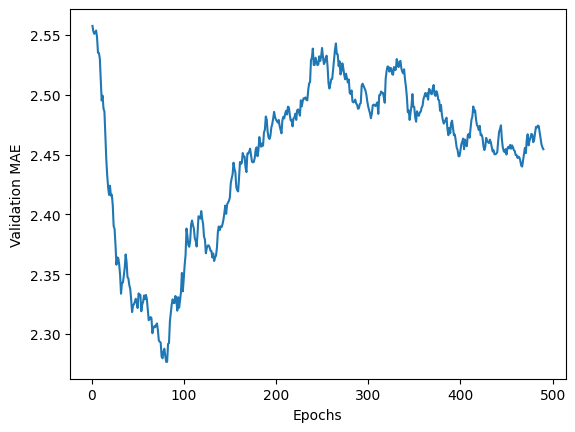

In [8]:
def smooth_curve(points, factor=0.9):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous*factor + point * (1-factor))
        else:
            smooth_points.append(point)
    return smooth_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [9]:
model = build_model()
model.fit(train_data, train_target, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)

4/4 [==============================] - 0s 2ms/step - loss: 15.6298 - mae: 2.5542
